In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

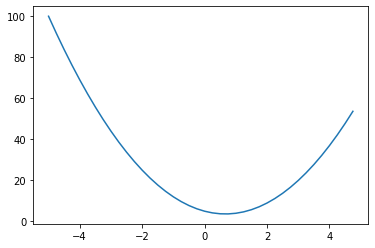

In [5]:
plt.plot(xs,ys)

In [6]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h 

2.999378523327323e-06

In [7]:
#let's get more complex
a = 2.0
b = -3.0
c = 10
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
c+= h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


#### Visualization of a simple expression

Forward pass

In [24]:
class Value:
    
    def __init__(self, data, _children =(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        return out
    
    
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'  #a.__add__(b)
d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c)
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'
L

Value(data = -8.0)

In [25]:
d._prev

{Value(data = -6.0), Value(data = 10.0)}

In [26]:
d._op

'+'

In [27]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

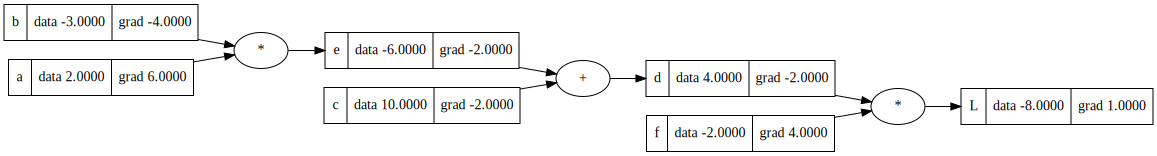

In [47]:
draw_dot(L)

In [48]:
a.data += 0.001*a.grad
b.data += 0.001*b.grad
c.data += 0.001*c.grad
f.data += 0.001*f.grad

e = a*b
d = e + c
L = d*f

print(L.data)

-7.928064095999999


Backpropogation

In [46]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0 * 1
e.grad = -2.0 * 1
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

dL / de = -2.0

e = a*b
de / da = b
de/db = a

dL / da = (dL/de) * (de / da)
dL/ da = -2.0 * -3
& 
dL / db = -2.0 * 2.0

---------------------------------

In [45]:
def lol():
    h = 0.0001
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'  #a.__add__(b)
    d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c)
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L1 =L.data
    
    a = Value(2.0 , label = 'a')
    a.data += h
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'  #a.__add__(b)
    d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c)
    f = Value(-2.0 , label = 'f')
    L = d*f; L.label = 'L'
    L2 =L.data 
    
    print((L2-L1)/h)
lol()

6.000000000021544


#### Neuron

In the belowexample we are going to use tanh activation function

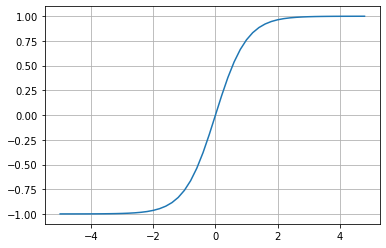

In [50]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.grid();

In [52]:
class Value:
    
    def __init__(self, data, _children =(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t,(self, ), 'tanh')
        return out

In [58]:
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1 and w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias b
b = Value(6.8813735870195432, label ='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

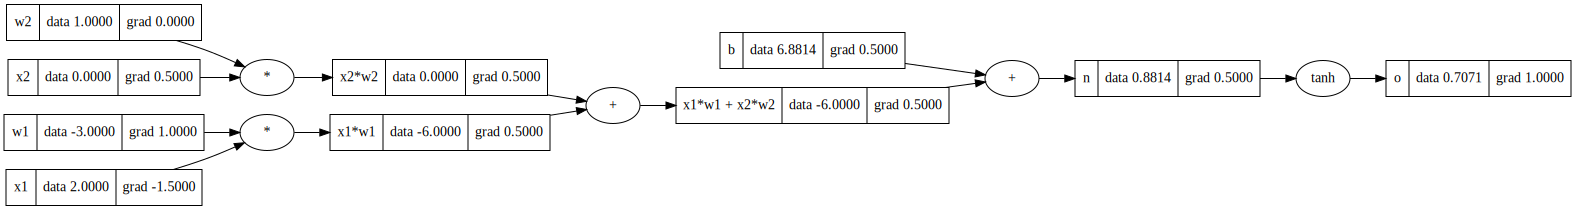

In [73]:
draw_dot(o)

In [72]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad 

In [71]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [68]:
#similarly we have + operation and the backpropogation will work the same way and distribute the gradient
x1w1.grad = 0.5
x2w2.grad = 0.5

In [66]:
x1w1x2w2.grad = 0.5
b.grad = 0.5
#since the + operation just distributes the gradient equally to the nodes

In [64]:
n.grad = 0.5

In [60]:
o.grad = 1.0

In [63]:
1 - o.data**2

0.4999999999999999

 o = tanh(n)
 do/dn = 1 - tanh(n)**2
        = 1 - o**2
        = 1 - o.data**2
        
 

#### Implementing backpropogation in our function

In [108]:
class Value:
    
    def __init__(self, data, _children =(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t,(self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [104]:
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1 and w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias b
b = Value(6.8813735870195432, label ='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

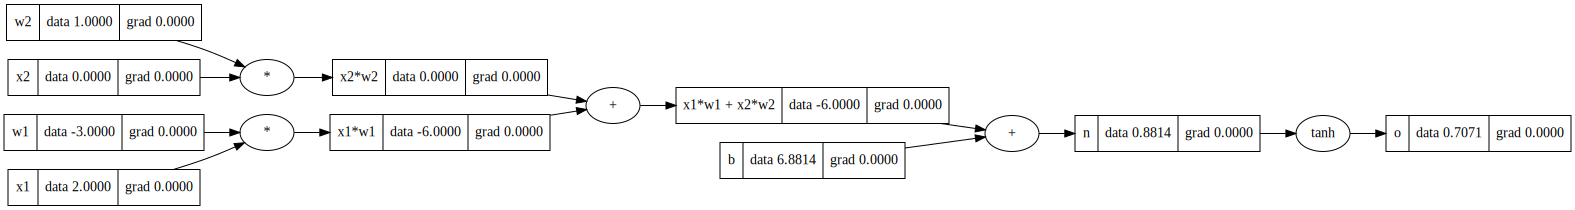

In [105]:
draw_dot(o)

In [106]:
o.backward()

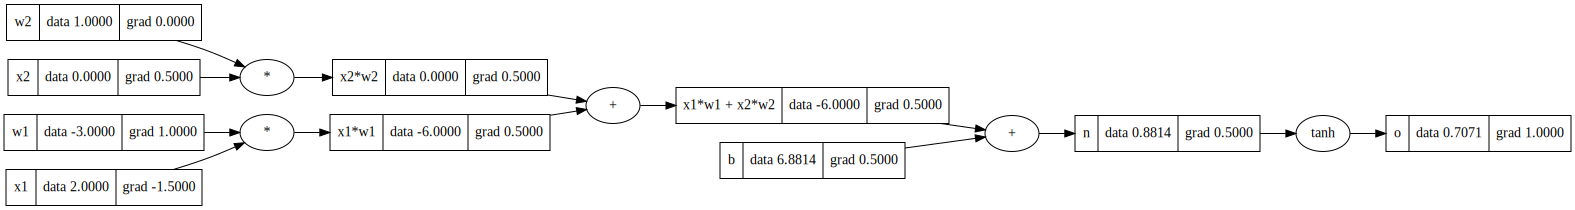

In [107]:
draw_dot(o)

In [100]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data = -3.0),
 Value(data = 2.0),
 Value(data = -6.0),
 Value(data = 0.0),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = -6.0),
 Value(data = 6.881373587019543),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

In [83]:
o.grad = 1.0


In [85]:
o._backward()

In [87]:
n._backward()

In [89]:
b._backward()

In [91]:
x1w1x2w2._backward()

In [93]:
x2w2._backward()
x1w1._backward()

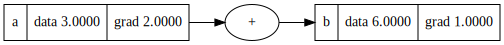

In [109]:
a = Value(3.0, label ='a')
b = a + a;b.label = 'b'
b.backward()
draw_dot(b)

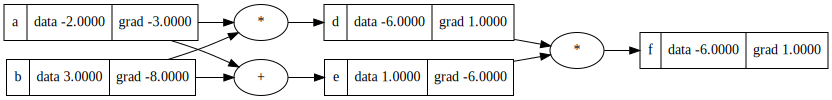

In [111]:
a = Value(-2.0,label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

#### breaking up the tanh function and excersing more options

In [147]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [136]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [124]:
a = Value(2.0)
a + 1 

Value(data = 3.0)

In [125]:
a * 2

Value(data = 4.0)

In [126]:
a = Value(2.0)

2 * a

Value(data = 4.0)

In [130]:
a = Value(2.0)

a.exp()

Value(data = 7.38905609893065)

In [134]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data = 0.5)

In [137]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data = -2.0)

In [138]:
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1 and w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias b
b = Value(6.8813735870195432, label ='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

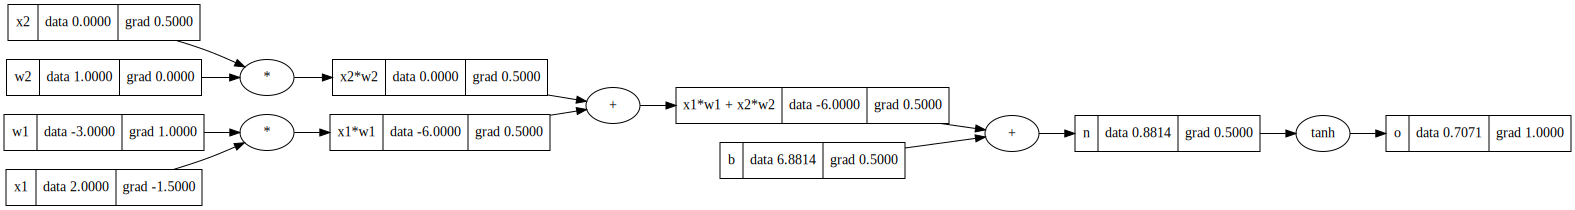

In [139]:
draw_dot(o)

In [148]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()

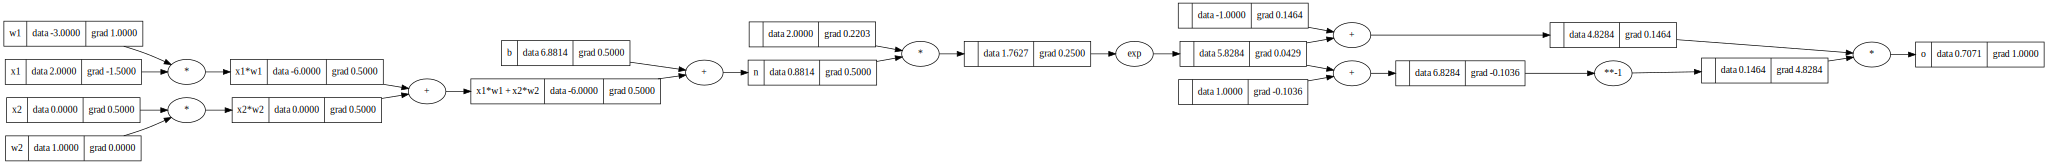

In [149]:
draw_dot(o)

In [150]:
import torch

In [155]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
